### Using Convolutional Neural Network
This is an extension of our work with the SVM model. Here, instead of using Sklearn's SVC function, we will use Keras with Tensorflow to build a CNN model to train and fit on. We can compare these results together.

In [30]:
import numpy as np
import os
from skimage.io import imread
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.externals import joblib

In [2]:
letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H','J', 'K', 'L', 'M', 'N','P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

letters_num = [i for i in range(0,len(letters))]

dictionary = dict(zip(letters, letters_num))

dict2 = dict(zip(letters_num, letters))

In [3]:
def read_training_data(training_directory):
    image_data =[]
    target_data=[]
    train_counter = 0
    img=[]
    amount = 3000
    for num in range(amount):
        for ltr in letters:
            img_path = os.path.join(training_directory, str(ltr), str(ltr) + '_' + str(num) + '.jpg')
            if os.path.exists(img_path)==True:
                try:
                    #print(img_path)
                    #img.append(np.array([1,2,3,4]))
                    img_details = imread(img_path, as_grey=True)
                    binary_image = img_details < threshold_otsu(img_details)
                    #print(binary_image.shape, type(binary_image))
                    flat_bin_image = binary_image.reshape(-1)
                    #flat_bin_image.tolist()
                    #print(type(flat_bin_image),flat_bin_image.shape )
                    #print(flat_bin_image.shape)
                    image_data.append(flat_bin_image)
                    #image_data.append(flat_bin_image)
                        #print(image_data)
                    target_data.append(ltr)
    
                except OSError as e:
                    os.remove(img_path)
                    print("Removed "+img_path)
            #train_counter+=1
    img=np.array(img)
    image_data = np.array(image_data)
    #image_data=image_data.flatten()
    target_data = np.array(target_data)
    #print(np.array(image_data).shape)
    print(image_data.shape,target_data.shape)       
    return (np.array(image_data), np.array(target_data))

In [4]:
current_dir = os.path.dirname(os.path.realpath("__file__"))

training_dataset_dir = os.path.join(current_dir, 'train/')
image_data, target_data = read_training_data(training_dataset_dir)

(68328,) (68328,)


In [10]:
image_data_reshaped=np.zeros((image_data.shape[0],400))
for i in range(image_data.shape[0]):
    image_data_reshaped[i,:] = image_data[i][0:400]

image_data_reshaped.shape

(68328, 400)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(image_data_reshaped, np.array(target_data), test_size=0.3, random_state=88)

In [13]:
X_train = X_train.reshape(X_train.shape[0],20, 20, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 20, 20,1).astype('float32')

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

In [15]:
temp = y_train
temp.shape
hold=[]
for tar in temp:
    v=dictionary[tar]
    hold.append(v)

temp2 = y_test
temp2.shape
hold2=[]
for array in temp2:
    v=dictionary[array]
    hold2.append(v)

In [16]:
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
Y_train = np_utils.to_categorical(hold)
Y_test = np_utils.to_categorical(hold2)
num_classes = 34

In [21]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(20,20,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.002), metrics=['accuracy'])
    return model

In [ ]:
def model1():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3),padding='valid', input_shape=(20,20,1), activation='relu'))
    model.add(Conv2D(64, (3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, (3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
def model2():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), input_shape=(20,20,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model.add(Conv2D(32, (5, 5), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
def build_fit_model():
    # build the model
    model = baseline_model()
    
    
    # Use callback to avoid no improvement training after 10 epochs
    cb=EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='auto')
    
    # Fit the model
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, callbacks=[cb],batch_size=32, verbose=2)
    
    # Final evaluation of the model
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print("CNN Error: %.2f%%" % (100-scores[1]*100))
    
    # serialize model to JSON
    model_json = model.to_json()
    with open("models/model_1.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model_l.h5")
    print("Saved model to disk")
    
    # Create plots to visual the loss and accuracy
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train on 47829 samples, validate on 20499 samples
Epoch 1/50
17s - loss: 1.2218 - acc: 0.6454 - val_loss: 0.4147 - val_acc: 0.8658
Epoch 2/50
16s - loss: 0.4304 - acc: 0.8502 - val_loss: 0.3074 - val_acc: 0.8922
Epoch 3/50
16s - loss: 0.3450 - acc: 0.8774 - val_loss: 0.2358 - val_acc: 0.9180
Epoch 4/50
16s - loss: 0.3058 - acc: 0.8893 - val_loss: 0.2217 - val_acc: 0.9252
Epoch 5/50
16s - loss: 0.2789 - acc: 0.8976 - val_loss: 0.1895 - val_acc: 0.9361
Epoch 6/50
16s - loss: 0.2574 - acc: 0.9067 - val_loss: 0.1778 - val_acc: 0.9427
Epoch 7/50
16s - loss: 0.2330 - acc: 0.9167 - val_loss: 0.1539 - val_acc: 0.9510
Epoch 8/50
16s - loss: 0.2175 - acc: 0.9216 - val_loss: 0.1424 - val_acc: 0.9541
Epoch 9/50
18s - loss: 0.2015 - acc: 0.9268 - val_loss: 0.1283 - val_acc: 0.9586
Epoch 10/50
17s - loss: 0.1883 - acc: 0.9331 - val_loss: 0.1076 - val_acc: 0.9675
Epoch 11/50
16s - loss: 0.1742 - acc: 0.9379 - val_loss: 0.1115 - val_acc: 0.9639
Epoch 12/50
16s - loss: 0.1633 - acc: 0.9407 - val_loss: 

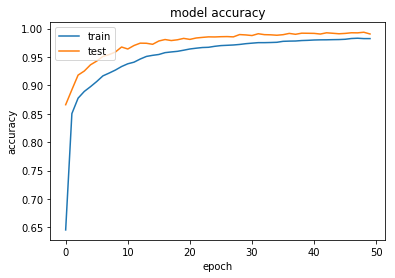

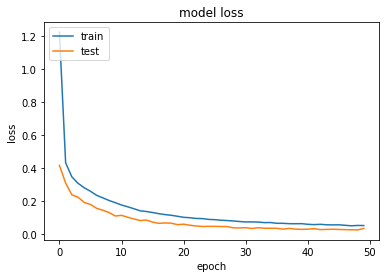

In [23]:
build_fit_model()

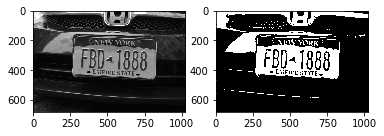

In [47]:
car_image_path="./cars/FBD1888.jpg"
car_image = imread(car_image_path, as_grey=True)

gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

In [28]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
from skimage.transform import resize

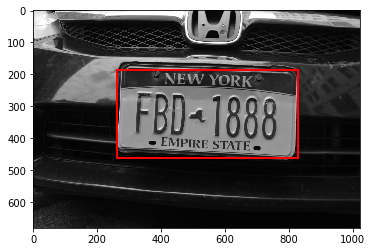

In [48]:
# this gets all the connected regions and allows use to iterate through them
label_image = measure.label(binary_car_image)


# From observation of the standard universal license plate, these are the dimensions we came up with
plate_dimensions = (0.3*label_image.shape[0], 0.5*label_image.shape[0], 0.3*label_image.shape[1], 0.6*label_image.shape[1])
#plate_dimensions = (0.1*label_image.shape[0], 0.25*label_image.shape[0], 0.25*label_image.shape[1], 0.5*label_image.shape[1])


min_height, max_height, min_width, max_width = plate_dimensions

plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

for region in regionprops(label_image):
    if region.area < 40:
        #if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row,
                                  min_col:max_col])
        plate_objects_cordinates.append((min_row, min_col,
                                              max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
    
plt.show()

/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/xiaosg/anacon

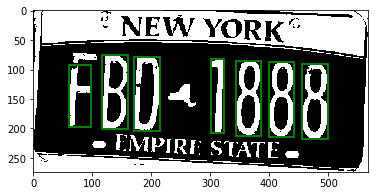

[116, 170, 301, 343, 400, 456, 60]

In [58]:
# Invert the colors b->w, w->b
license_plate = np.invert(plate_like_objects[0])
#license_plate = plate_like_objects[0]

labelled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

# Again from observation, we note the approximate proportions of the characters on the plate
#character_dimensions = (0.4*license_plate.shape[0], 0.8*license_plate.shape[0], 0.05*license_plate.shape[1], 0.4*license_plate.shape[1])
character_dimensions = (0.35*license_plate.shape[0], 0.9*license_plate.shape[0], 0.03*license_plate.shape[1], 0.4*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []

for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="green",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # keep track of the arrangement of the characters
        column_list.append(x0)

plt.show()

column_list

In [35]:
from keras.models import model_from_json

In [36]:

def load_model(model_name_path='models/model_l.json'):
    # load json and create model
    json_file = open(model_name_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model_l.h5")
    print("Loaded model from disk")
    
    return model

In [37]:
model=load_model()

Loaded model from disk


In [38]:
def predict_plate(characters,model, column_list):
    classification_result = []
    for each_character in characters:
        # converts it to a 1D array
        #each_character = each_character.reshape(1, -1)
        each_character = each_character.reshape((1,20, 20, 1))
        result = model.predict(each_character)
        classification_result.append(result)
    classification_result=np.array(classification_result).astype(int)
    print(classification_result, classification_result.shape)
    

    plate_string = ''
    for eachPredict in classification_result:
        #plate_string += eachPredict[0]
        predicted_letter = str(letters[np.argmax(eachPredict)])
        plate_string += predicted_letter

    print(plate_string)

    # it's possible the characters are wrongly arranged
    # since that's a possibility, the column_list will be
    # used to sort the letters in the right order

    column_list_copy = column_list[:]
    column_list.sort()
    rightplate_string = ''
    for each in column_list:
        rightplate_string += plate_string[column_list_copy.index(each)]

    print(rightplate_string)
    return classification_result, rightplate_string

In [59]:
cr, rightplate_string = predict_plate(characters, model, column_list)

[[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]] (7, 1, 34)
801888M
M801888


In [41]:
Y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [42]:
letters

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']